In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
import os

des_arr = np.array([])
for image in os.listdir('train'):
    path = os.path.join('train',image)
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    _, des = sift.detectAndCompute(img,None)
    des_arr = des if des_arr.size == 0 else np.vstack((des_arr, des))


KeyboardInterrupt: 

In [28]:
#np.savetxt("des_array.csv", des_arr, delimiter=",")

In [4]:
from sklearn.cluster import KMeans

In [31]:


kmeans = KMeans(n_clusters=512, random_state=0).fit(des_arr)

In [6]:
from joblib import dump, load
#dump(kmeans, 'kmeans.joblib') 


In [7]:
kmeans = load('kmeans.joblib')

In [21]:
def vectorize_image(image:np.array,model,n_clusters=512):
    _,des = sift.detectAndCompute(image,None)
    classes = model.predict(des)
    hist = np.zeros(n_clusters)
    for clss in classes:
        hist[clss] += 1

    hist /= len(classes)
    return hist


In [8]:
db_csv_name = 'db.csv'

In [98]:


ind = 0
for image in os.listdir('db'):
    ind += 1
    path = os.path.join('db',image)
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    df = pd.DataFrame(data={'uid':ind,'filepath':path,'encoding_vector':[vectorize_image(img,kmeans)]})
    df.set_index('uid', inplace=True)
    df['encoding_vector'] = df['encoding_vector'].apply(lambda x: np.array2string(x, separator=','))
    df.to_csv(db_csv_name, mode='a', header=not os.path.exists(db_csv_name),sep='\t')
    


In [9]:
import pandas as pd

In [10]:
db = pd.read_csv('db.csv',delimiter='\t')
db['encoding_vector'] = db['encoding_vector'].apply(lambda x: eval(x))


In [15]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine',n_jobs=-1).fit(np.vstack(db['encoding_vector'].values), db['uid'].values)

In [16]:
dump(nbrs, 'nbrs.joblib') 

['nbrs.joblib']

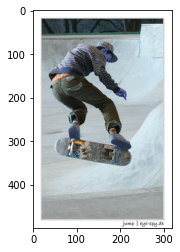

In [62]:
img = cv.imread('db/2012_004299.jpg')
plt.imshow(img)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [63]:
t_img = vectorize_image(img,kmeans)

In [64]:
_,h = nbrs.kneighbors([t_img],n_neighbors=5)

In [65]:
h

array([[1652,  235,  521, 1547,  222]], dtype=int64)

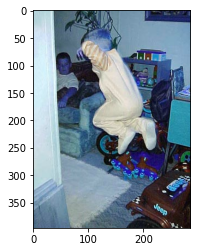

In [69]:
plt.imshow(cv.imread(db.loc[222]['filepath']))

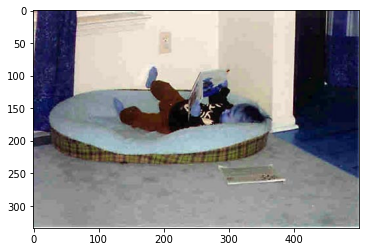

In [60]:
plt.imshow(cv.imread(db.loc[1291]['filepath']))

In [ ]:
def find_similar(img,n_similar):
    img_vec = vectorize_image(cv.cvtColor(img, cv.COLOR_BGR2GRAY),kmeans)
    _,inds = nbrs.kneighbors([img_vec],n_neighbors=5)
    return inds.flatten()
    